In [1]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25))

In [99]:
def getdata(term):
	kw_list = [term]
	pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')
	df = pytrends.interest_over_time()
	return df

In [82]:
def plotdata(term):
    df = getdata(term)
    df.plot()

In [28]:
stocks = pd.read_csv("~/desktop/daily_stocks.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [137]:
newstocks = stocks[stocks['date']>20150000] # Restrict to data after 2015

In [138]:
newstocks.head()

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX
2014,10026,20150102,JJSF,106.810,109.446,107.69,107.45,107.69,109.18,-0.009929
2015,10026,20150105,JJSF,106.760,108.430,107.24,107.25,107.39,107.41,-0.004179
2016,10026,20150106,JJSF,106.185,108.690,107.27,107.25,107.55,107.84,0.000280
2017,10026,20150107,JJSF,106.495,108.770,108.73,108.62,108.75,107.70,0.013611
2018,10026,20150108,JJSF,109.110,111.280,110.32,110.31,110.71,109.48,0.014623


In [123]:
def find_date_string(row):
    ds = str(row['date']-1)
    dates = ds[:4] + "-" + ds[4:6] + "-" + ds[6:]
    return dates

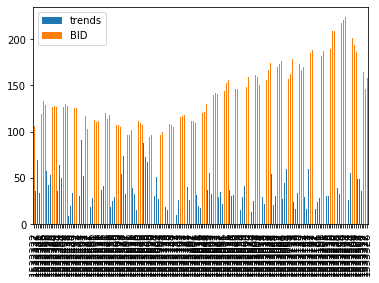

In [136]:
aapl.plot(y=['trends', 'BID'], kind='bar')

In [146]:
def getdf(ticker):
    df = newstocks[newstocks["TICKER"]==ticker]
    df['date_string'] = df.apply(lambda row: find_date_string(row), axis=1)
    trends_data = getdata(ticker)
    s = set(trends_data.index.values)
    s = set([str(x)[:10] for x in s])
    df = df[df['date_string'].isin(s)]
    df['trends'] = df.apply(lambda row: trends_data.loc[row['date_string']][ticker], axis=1)
    #df.plot(y=['BID','trends'], kind='bar')
    df.plot(y='trends')
    df.plot(y='BID')
    return df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX,date_string,trends
17888,10107,20150105,MSFT,46.2500,46.7300,46.325,46.32,46.33,46.37,-0.009303,2015-01-04,17
17893,10107,20150112,MSFT,46.3600,47.5400,46.600,46.61,46.62,47.42,-0.012503,2015-01-11,17
17902,10107,20150126,MSFT,46.2399,47.1339,47.010,47.00,47.01,47.00,-0.003603,2015-01-25,47
17907,10107,20150202,MSFT,40.2300,41.3700,41.280,41.27,41.28,40.59,0.021782,2015-02-01,26
17912,10107,20150209,MSFT,42.2100,42.7400,42.360,42.35,42.36,42.24,-0.001179,2015-02-08,23
...,...,...,...,...,...,...,...,...,...,...,...,...
18874,10107,20181203,MSFT,110.7300,113.4200,112.090,112.09,112.10,113.00,0.010822,2018-12-02,48
18878,10107,20181210,MSFT,103.8900,107.9800,107.590,107.53,107.54,104.80,0.026426,2018-12-09,44
18883,10107,20181217,MSFT,101.7100,105.8000,102.890,102.95,102.98,105.41,-0.029614,2018-12-16,48
18888,10107,20181224,MSFT,93.9800,97.9700,94.130,94.00,94.04,97.68,-0.041739,2018-12-23,48


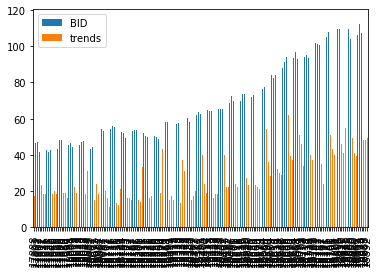

In [144]:
getdf("MSFT")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


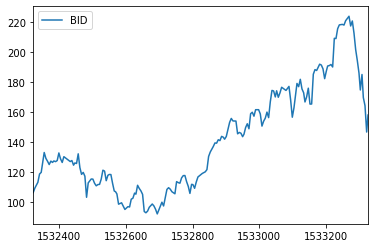

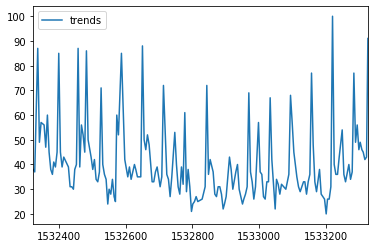

In [141]:
getdf("AAPL")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX,date_string,trends
5965502,84788,20150105,AMZN,300.85001,308.38000,302.19000,302.10001,302.19000,307.01001,-0.020517,2015-01-04,6
5965507,84788,20150112,AMZN,289.28101,298.51001,291.41000,291.39999,291.41000,297.56000,-0.01859,2015-01-11,6
5965516,84788,20150126,AMZN,307.52011,313.00000,309.66000,309.64999,309.66000,311.82001,-0.008739,2015-01-25,18
5965521,84788,20150202,AMZN,350.01001,365.00000,364.47000,364.50000,364.59000,350.04999,0.028037,2015-02-01,12
5965526,84788,20150209,AMZN,367.20001,374.41000,370.56000,370.56000,370.59000,371.00000,-0.009939,2015-02-08,8
...,...,...,...,...,...,...,...,...,...,...,...,...
5966488,84788,20181203,AMZN,1730.00000,1778.33997,1772.35999,1772.67004,1772.89001,1769.45996,0.048628,2018-12-02,58
5966492,84788,20181210,AMZN,1590.87000,1657.98999,1641.03003,1640.38000,1641.18005,1623.83997,0.007305,2018-12-09,50
5966497,84788,20181217,AMZN,1505.01001,1576.13000,1520.91003,1520.26001,1522.13000,1566.00000,-0.044601,2018-12-16,61
5966502,84788,20181224,AMZN,1307.00000,1396.03003,1343.95996,1342.68005,1342.91003,1346.00000,-0.024313,2018-12-23,58


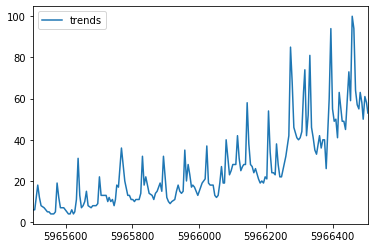

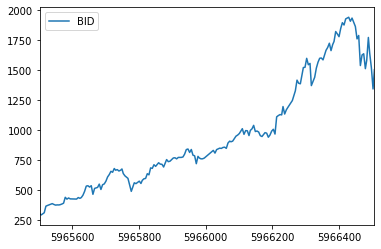

In [147]:
getdf("AMZN")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,BID,ASK,OPENPRC,RETX,date_string,trends
10607559,93436,20150105,TSLA,207.16260,216.50000,210.09000,210.00999,210.10001,214.55000,-0.042041,2015-01-04,9
10607564,93436,20150112,TSLA,199.25000,204.47000,202.21001,202.19000,202.21001,203.05000,-0.021533,2015-01-11,14
10607573,93436,20150126,TSLA,201.05000,208.62000,206.55000,206.53999,206.59000,201.83000,0.026132,2015-01-25,10
10607578,93436,20150202,TSLA,203.30000,211.94991,210.94000,210.92999,211.05000,203.97000,0.036051,2015-02-01,11
10607583,93436,20150209,TSLA,211.99001,217.92999,217.48000,217.44000,217.49001,215.38000,0.000552,2015-02-08,23
...,...,...,...,...,...,...,...,...,...,...,...,...
10608545,93436,20181203,TSLA,352.00000,366.00000,358.48999,358.48999,358.63000,360.00000,0.022854,2018-12-02,27
10608549,93436,20181210,TSLA,353.12000,365.98001,365.14999,365.14001,365.14999,360.00000,0.020072,2018-12-09,28
10608554,93436,20181217,TSLA,343.88000,365.70001,348.42001,348.35999,348.42001,362.00000,-0.047278,2018-12-16,25
10608559,93436,20181224,TSLA,295.19501,314.50000,295.39001,295.45999,295.67001,313.50000,-0.076242,2018-12-23,25


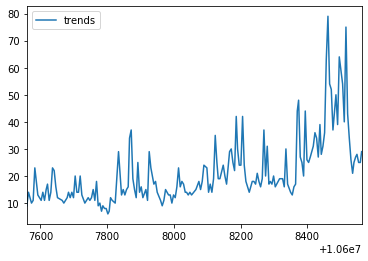

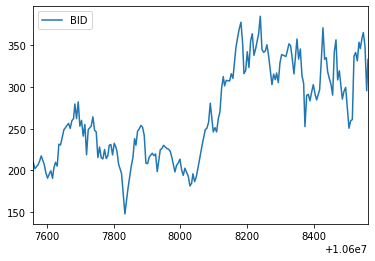

In [149]:
getdf("TSLA")